In [ ]:
%%capture
!pip install torch-geometric==2.5.0
!pip install trimesh
!pip install differentiable-voronoi
!pip install gradnorm-pytorch

In [ ]:
from differentiable_voronoi import differentiable_voronoi, triangulate
from shapely import Polygon, LineString, Point
import matplotlib.pyplot as plt
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import to_dense_adj, to_undirected, degree, to_dense_batch
from copy import deepcopy
import numpy as np
from sklearn.cluster import KMeans, SpectralClustering, BisectingKMeans
from trimesh import Trimesh
from scipy.spatial import Delaunay
import matplotlib.patches
from shapely.geometry.polygon import orient
from scipy.spatial import Voronoi, voronoi_plot_2d
from torch_geometric.nn.pool import avg_pool_x
import copy
from torch.nn import MSELoss
from IPython.display import clear_output
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KDTree
from time import sleep
import time
import matplotlib.cm as cm

##Solver

In [ ]:
class WaveSolver(MessagePassing):
    """Graph solver class"""
    def init(self):
        super().init(aggr='add', flow='target_to_source')
    def calc_weights(self, e, h, edge_index):
        numerator =  e
        denominator = h + 1e-18
        assert numerator.shape == denominator.shape
        return torch.divide(numerator, denominator)

    def forward(self, u_nm1, u, v, h, e, k, w, p_bhp, dt, edge_index):
        assert ~torch.any(torch.isnan(u))
        assert ~torch.any(torch.isnan(v))
        assert ~torch.any(torch.isnan(h))
        assert ~torch.any(torch.isnan(e))
        assert ~torch.any(torch.isnan(k))
        assert len(u) == len(v), print(len(u), len(v))
        assert len(h) == len(e) == edge_index.shape[1]
        assert len(u) == len(p_bhp) == len(w) == len(k)
        #assert torch.all(u >= 0), print(u)
        assert torch.all(v > 0)
        assert torch.all(h > 0)
        assert torch.all(e >= 0)
        assert torch.all(k > 0)
        assert torch.all(w >= 0)
        #assert torch.all(p_bhp >= 0)


        weights = self.calc_weights(e, h, edge_index).view(-1, 1)
        assert ~torch.any(torch.isnan(weights))
        assert len(weights) == edge_index.shape[1], print(len(weights), len(edge_index))
        #todo switch
        edge_index, weights = to_undirected(edge_index, weights)
        assert torch.all(weights >= 0)
        div = self.propagate(edge_index=edge_index, x=u, weights=weights)
        assert len(div) == len(u)
        t2_over_V = (dt**2) / v
        # added multiplication by k
        return -u_nm1 + 2 * u - k * t2_over_V * div

    def message(self, x_i, x_j, weights):
        du = x_i - x_j
        return weights * du

def roll_out_wave(solver, n_steps, u0, v, h, e, k, w, p_bhp, dt, edge_index, keep=0, save_animation=False, every_nth=10):
    animation = []
    roll = torch.zeros((len(keep), n_steps))
    roll[:,0] = u0[keep].squeeze().T



    u_nm1 = u0
    weights = solver.calc_weights(e, h, edge_index).view(-1, 1)
    edge_index_undirected, weights_undirected = to_undirected(edge_index, weights)

    div = solver.propagate(edge_index=edge_index_undirected, x=u0, weights=weights_undirected)
    t2_over_V = 0.5*(dt**2) / v
    div=div.squeeze()
    div = (t2_over_V * div).unsqueeze(1)
    u_n = u0 - k.unsqueeze(1)*div
    roll[:, 1] = u_n[keep].squeeze().T


    for i in range(2, n_steps):
        u = solver(u_nm1=u_nm1, u=u_n, v=v.view(-1, 1), h=h, e=e, k=k.view(-1,1), w=w, p_bhp=p_bhp, dt=dt, edge_index=edge_index)
        u_nm1 = u_n
        u_n = u

        roll[:, i] = u[keep].squeeze()


    return roll


def calc_h(coords, edge_index):
    x_i, x_j = coords[edge_index[0]], coords[edge_index[1]]
    return torch.norm(x_i - x_j, dim=1)

def dynamics_wave(point_cloud, sources, sinks, boundary,  u0, dt=0.0001, n_steps=10000, save_animation=False):
    COORDS = torch.tensor(point_cloud[:, :2], dtype=torch.float32, requires_grad=False)
    mesh = triangulate(COORDS.clone().detach())

    edge_index, areas, e, _ = differentiable_voronoi(COORDS, mesh, boundary)
    assert len(COORDS) == len(areas), print(len(COORDS), len(areas), areas)
    h = calc_h(COORDS, edge_index)

    perm = torch.tensor(point_cloud[:, 2], requires_grad=False)

    p_bhp = torch.zeros((len(COORDS), 1), requires_grad=False)
    w = torch.zeros((len(COORDS), 1), requires_grad=False)

    solver = WaveSolver()

    return roll_out_wave(solver, n_steps=n_steps, u0=u0, v=areas, h=h, e=e, k=perm, w=w, p_bhp=p_bhp, dt=dt,
                                 edge_index=edge_index, keep=sinks, save_animation=save_animation)

##Initial data

In [ ]:

L = 1.0

x_grid, y_grid = np.meshgrid(np.linspace(0, 1.0, 70), np.linspace(0, 1.0, 70))
x = x_grid.flatten().reshape(-1, 1)
y = y_grid.flatten().reshape(-1, 1)
c = np.ones((len(x),1))
field = np.concatenate([x, y, c], axis=1)


sensor_index = []
for j in range(5):
  for i in range(5):
    sensor_index.append(4900 - 140 -700*j + 15 +10*i)

eps = 0.0

task = {'field':field,
      'sources': {}, #not used
      'sensors': sensor_index,
      'dt': 0.005,
      'boundary': torch.tensor([[-eps,-eps],
                                  [-eps, L + eps],
                                   [L + eps, L + eps],
                                    [L + eps, -eps]], requires_grad=False),
      'n_steps':200}


u0 = 1*(0.25**2 - np.square(task['field'][:,0] - 0.5) - np.square(task['field'][:,1] - 1.0))
u0[u0 < 0] = 0.0
u0 = u0[:,np.newaxis]

u0 = torch.tensor(u0, requires_grad=False)


In [ ]:
field.shape

(4900, 3)

(np.float64(-0.05), np.float64(1.05), np.float64(-0.05), np.float64(1.05))

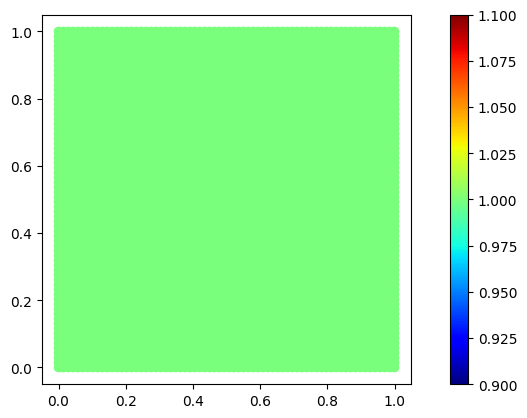

In [ ]:
scatter = plt.scatter(task['field'][:,0],task['field'][:,1] , c=task['field'][:,2],  cmap=plt.cm.jet)
plt.colorbar(scatter)
plt.axis('scaled')

(np.float64(-0.05), np.float64(1.05), np.float64(-0.05), np.float64(1.05))

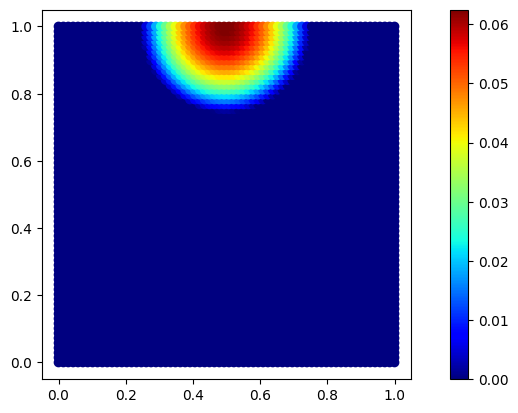

In [ ]:
scatter = plt.scatter(task['field'][:,0],task['field'][:,1] , c=u0,  cmap=plt.cm.jet)
plt.colorbar(scatter)
plt.axis('scaled')

In [ ]:
ground_truth_dynamics_1 = dynamics_wave(task['field'], task['sources'],
                  task['sensors'], task['boundary'], dt=task['dt'],
                  n_steps=task['n_steps'], save_animation=False , u0=u0)

/tmp/ipython-input-4091904744.py:48: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4421.)
  roll[:,0] = u0[keep].squeeze().T


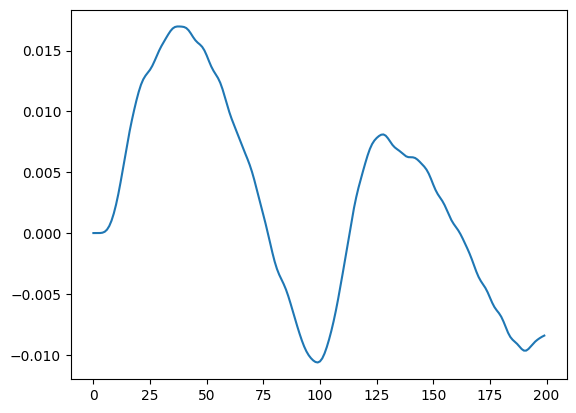

In [ ]:
plt.plot(ground_truth_dynamics_1[0])

In [ ]:
ground_truth_dynamics_1.shape

torch.Size([25, 200])

##Task 1

$$\frac{\partial^2 u}{\partial t^2} - c^2 \Delta u = 0$$

$$
u = U_0(x,y) \quad \text{when } t=0
$$

$$
\frac{\partial u}{\partial t} = 0 \quad \text{when } t=0
$$

$$
\frac{\partial u}{\partial n} = 0 \quad \text{on boundary}
$$

$$
\min_{U_0}{L(U_0)} = \sum_{i=1}^m \int_0^T \big( u_{\mathrm{mod}}^i(t) - u_{\mathrm{obs}}^i(t) \big)^2 \, dt + \beta \int_V U_0(x,y)^2 \, dx dy
$$

Exsercise: define loss function and optimizer


In [ ]:
def phys_loss_func(ground_truth_dynamics,modeled_dynamics,dt):
  return torch.sum(torch.sum((ground_truth_dynamics - modeled_dynamics)**2, dim=1)* dt)


In [ ]:
def stab_loss_func_L2(u0_cur,areas,beta):
  return beta * torch.sum((u0_cur** 2) * areas)

In [ ]:
def estimate_u0(point_cloud, boundary, sources, sensors, ground_truth_dynamics,
                dt, n_steps, true_u0, n_epochs, function_for_phys_loss, function_for_stab_loss,
                beta=1.0, lr=0.1):
    # Ensure ground_truth_dynamics has correct dimensions: [num_sensors x num_timesteps]
    assert ground_truth_dynamics.shape[0] == len(sensors)
    assert ground_truth_dynamics.shape[1] == n_steps

    n = point_cloud.shape[0]  # Number of points in the point cloud

    # Triangulate point cloud to create mesh for spatial discretization
    mesh = triangulate(point_cloud[:, :2])

    # Convert point coordinates to tensor without requiring gradients (fixed input)
    xys = torch.tensor(point_cloud[:, :2], requires_grad=False)

    # Initialize u0 (initial wave function/state) as zeros with gradient tracking enabled for optimization
    u0_cur = torch.zeros((n, 1), requires_grad=True, dtype=torch.float)

    # Initialize other physical parameters as tensors, no gradients needed
    p_bhp = torch.zeros((n, 1), requires_grad=False)  # boundary pressure or similar
    w = torch.zeros((n, 1), requires_grad=False)      # possibly source/sink terms
    k = torch.tensor(point_cloud[:, 2], requires_grad=False)  # property like permeability from point_cloud

    loss_curve = []  # To store loss values over training epochs

    with torch.no_grad():
        # Compute differentiable Voronoi tessellation for mesh edges, areas, etc.
        edge_index, areas, e, clipped_vertices_dict = differentiable_voronoi(xys, mesh, boundary)
        # Calculate spatial discretization parameter h based on edges
        h = calc_h(xys, edge_index)

    solver = WaveSolver()  # Initialize wave equation solver instance
    physical_loss = None   # Placeholder for physical loss value
    modeled_dynamics = None  # Placeholder for predicted dynamics

    # Lists to record various diagnostic losses per epoch
    phys_loss_values, stability_loss_values = [], [], [], [], []

    # Define optimizer for u0_cur variables to minimize loss
    optimizer = torch.optim.Adam([u0_cur], lr=lr)

    for i in range(n_epochs):
        print("epoch ", i)
        optimizer.zero_grad()  # Reset gradients before backward pass

        with torch.no_grad():
            # Print statistics of current estimate u0_cur for monitoring
            print("u0_cur ", " min/max: ", torch.min(u0_cur).item(), torch.max(u0_cur).item())
            # Compute and print L2 error between current estimate and true initial condition
            print('error for u_0:', torch.sqrt(torch.sum((u0_cur - true_u0)**2)).item())

        # Roll out wave dynamics simulation given current u0 estimate and mesh parameters
        modeled_dynamics = roll_out_wave(
            solver, n_steps=n_steps, u0=u0_cur, v=areas, h=h, e=e,
            k=k, w=w, p_bhp=p_bhp, dt=dt,
            edge_index=edge_index, keep=sensors
        )
        # Check shapes match for ground truth and modeled dynamics
        assert ground_truth_dynamics.shape == modeled_dynamics.shape

        # Compute physical loss comparing simulation results to ground truth
        physical_loss = function_for_phys_loss(ground_truth_dynamics, modeled_dynamics, dt)
        phys_loss_values.append(physical_loss)

        # Compute stability regularization loss on u0_cur
        stab_loss = function_for_stab_loss(u0_cur, areas.view(-1, 1), beta)
        stability_loss_values.append(stab_loss)

        # Total loss is sum of physical mismatch and stability regularization
        loss = physical_loss + stab_loss
        print('loss ', loss.item(), "phys ", physical_loss.item(), "stab ", stab_loss.item())
        loss.backward()  # Backpropagate loss to calculate gradients

        loss_curve.append(loss.item())  # Record current loss

        optimizer.step()  # Update u0_cur parameters using gradients

        with torch.no_grad():
            if i % 10 == 0 or i == (n_epochs - 1):  # Every 10 epochs and last epoch display plots

                fig = plt.figure(figsize=(14, 14))
                ((ax1, ax2), (ax3, ax4)) = fig.subplots(2, 2)

                # Plot true initial state u0 if available
                if true_u0 is not None:
                    scatter = ax1.scatter(point_cloud[:, 0], point_cloud[:, 1], c=true_u0, cmap=cm.jet)
                    ax1.scatter(point_cloud[sensors, 0], point_cloud[sensors, 1], marker='D', c='k')  # sensor locations
                    ax1.set_title("True u0")
                    plt.colorbar(scatter, ax=ax1)

                # Plot recovered initial state u0_cur
                scatter = ax2.scatter(point_cloud[:, 0], point_cloud[:, 1], c=u0_cur.detach().numpy(), cmap=cm.jet)
                ax2.scatter(point_cloud[sensors, 0], point_cloud[sensors, 1], marker='D', c='k')
                ax2.set_title("Recovered u0")
                plt.colorbar(scatter, ax=ax2)

                # Plot temporal dynamics for a sample sensor (or all sensors if uncommented loop)
                if modeled_dynamics is not None:
                    #for j in range(len(sensors)):
                    for j in range(1):
                        ax3.plot(np.linspace(0.0, dt * n_steps, n_steps), ground_truth_dynamics.detach().numpy()[j, :], label='data ' + str(j + 1))
                        ax3.plot(np.linspace(0.0, dt * n_steps, n_steps), modeled_dynamics.detach().numpy()[j, :], label='fitting ' + str(j + 1))
                    ax3.grid()
                    ax3.legend()
                    ax3.set(xlabel='t, s', ylabel='p, Pa')

                # Plot loss curves over epochs on logarithmic scale
                if physical_loss is not None:
                    ax4.plot(range(1, 1 + len(phys_loss_values)), phys_loss_values, label='physical loss', color='red')
                    ax4.plot(range(1, 1 + len(stability_loss_values)), stability_loss_values, label='stabilizer', color='black')
                    ax4.set_yscale("log")
                    ax4.grid()
                    ax4.legend()
                    ax4.set(xlabel='epoch')

                fig.suptitle("epoch " + str(i))
                plt.show()


                # clear_output(wait=True)

    return loss_curve


In [ ]:
estimate_u0(task['field'], task['boundary'],task['sources'],
                  task['sensors'], dt=task['dt'],ground_truth_dynamics = ground_truth_dynamics_1,
                  n_steps=task['n_steps'],true_u0 = u0, n_epochs = 100,function_for_phys_loss= phys_loss_func,function_for_stab_loss=stab_loss_func_L2,beta = 0.1,lr=0.01)

##Task 2

1) Run a simulation with beta = 100

2) Run a simulation with only first ten sensor points

3) Run a simulation with only last five sensor points

In [ ]:
ground_truth_dynamics_1.shape

torch.Size([25, 200])

In [ ]:
estimate_u0(task['field'], task['boundary'],task['sources'],
                  task['sensors'], dt=task['dt'],ground_truth_dynamics = ground_truth_dynamics_1,
                  n_steps=task['n_steps'],true_u0 = u0, n_epochs = 100,function_for_phys_loss= phys_loss_func,function_for_stab_loss=stab_loss_func_L2,beta = 100.0,lr=0.01)

In [ ]:
estimate_u0(task['field'], task['boundary'],task['sources'],
                  task['sensors'][20:], dt=task['dt'],ground_truth_dynamics = ground_truth_dynamics_1[20:],
                  n_steps=task['n_steps'],true_u0 = u0, n_epochs = 100,function_for_phys_loss= phys_loss_func,function_for_stab_loss=stab_loss_func_L2,beta = 0.1,lr=0.01)

In [ ]:
estimate_u0(task['field'], task['boundary'],task['sources'],
                  task['sensors'][:5], dt=task['dt'],ground_truth_dynamics = ground_truth_dynamics_1[:5],
                  n_steps=task['n_steps'],true_u0 = u0, n_epochs = 100,function_for_phys_loss= phys_loss_func,function_for_stab_loss=stab_loss_func_L2,beta = 0.1,lr=0.01)

##Task 3

$$
L(U_0) = \sum_{i=1}^m \int_0^T \big( u_{\mathrm{mod}}^i(t) - u_{\mathrm{obs}}^i(t) \big)^2 \, dt + \beta \int_V |U_0(x,y)| \, dx dy
$$

In [ ]:
def stab_loss_func_L1(u0_cur,areas,beta):
  return beta * torch.sum((abs(u0_cur)) * areas)

In [ ]:
estimate_u0(task['field'], task['boundary'],task['sources'],
                  task['sensors'], dt=task['dt'],ground_truth_dynamics = ground_truth_dynamics_1,
                  n_steps=task['n_steps'],true_u0 = u0, n_epochs = 100,function_for_phys_loss= phys_loss_func,function_for_stab_loss=stab_loss_func_L1,beta = 0.1,lr=0.01)

##Task 4
$$
L(U_0) = \sum_{i=1}^m \int_0^T w_i(t)\big( u_{\mathrm{mod}}^i(t) - u_{\mathrm{obs}}^i(t) \big)^2 \, dt + \beta \int_V |U_0(x,y)| \, dx dy
$$

$w_i(t) = \frac{1}{t+\alpha}$

In [ ]:
def phys_loss_func_with_modifiacation(ground_truth_dynamics,modeled_dynamics,dt,alpha = 0.01):

  n_steps = ground_truth_dynamics.shape[1]
  times = torch.arange(n_steps, dtype=torch.float32) * dt
  weights = 1.0 / (times + alpha)
  weights = weights.view(1, n_steps)
  return torch.sum(torch.sum(weights*(ground_truth_dynamics - modeled_dynamics)**2, dim=1)* dt)

In [ ]:
estimate_u0(task['field'], task['boundary'],task['sources'],
                  task['sensors'], dt=task['dt'],ground_truth_dynamics = ground_truth_dynamics_1,
                  n_steps=task['n_steps'],true_u0 = u0, n_epochs = 100,function_for_phys_loss= phys_loss_func_with_modifiacation,function_for_stab_loss=stab_loss_func_L1,beta = 0.1,lr=0.01)

##Task 5

Add some gaussian noise for initial data

In [ ]:
noise_std = 0.1 * torch.std(ground_truth_dynamics_1)
noise = torch.normal(mean=0.0, std=noise_std, size=ground_truth_dynamics_1.shape)
ground_truth_dynamics_noisy = ground_truth_dynamics_1 + noise

In [ ]:
estimate_u0(task['field'], task['boundary'],task['sources'],
                  task['sensors'], dt=task['dt'],ground_truth_dynamics = ground_truth_dynamics_noisy,
                  n_steps=task['n_steps'],true_u0 = u0, n_epochs = 100,function_for_phys_loss= phys_loss_func_with_modifiacation,function_for_stab_loss=stab_loss_func_L1,beta = 0.1,lr=0.01)